In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

We have used time domain features as input to SVM. First data for each fault type are collected and segmented into smaller parts. 
In our case, one segment for each fault type contains 2048 data points.
 Then time domain features for each segment are calculated and assembled in a feature matrix. 
 There are 230 segments for each fault and we have taken 9 time domain features.
  The time domain features are maximum, minimum, mean value, standard deviation, root mean square value (RMS), skewness, kurtosis, crest factor, and form factor. 
  Thus our feature matrix is of size . One column containing fault type is also added to the feature matrix. Thus final feature matrix is of size .

In [2]:
df = pd.read_csv('feature_time_48k_2048_load_1.csv')
df

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault
0,0.35986,-0.41890,0.017840,0.122746,0.124006,-0.118571,-0.042219,2.901946,6.950855,Ball_007_1
1,0.46772,-0.36111,0.022255,0.132488,0.134312,0.174699,-0.081548,3.482334,6.035202,Ball_007_1
2,0.46855,-0.43809,0.020470,0.149651,0.151008,0.040339,-0.274069,3.102819,7.376926,Ball_007_1
3,0.58475,-0.54303,0.020960,0.157067,0.158422,-0.023266,0.134692,3.691097,7.558387,Ball_007_1
4,0.44685,-0.57891,0.022167,0.138189,0.139922,-0.081534,0.402783,3.193561,6.312085,Ball_007_1
...,...,...,...,...,...,...,...,...,...,...
2295,0.21425,-0.19839,0.010769,0.064100,0.064983,-0.212497,-0.119312,3.297037,6.034174,Normal_1
2296,0.21967,-0.20882,0.013136,0.068654,0.069883,-0.061308,-0.295122,3.143410,5.319958,Normal_1
2297,0.20799,-0.21613,0.012571,0.067128,0.068279,-0.154754,-0.071405,3.046161,5.431299,Normal_1
2298,0.21425,-0.22405,0.012608,0.066813,0.067977,-0.326966,0.023662,3.151821,5.391672,Normal_1


In [3]:
df['fault'] = pd.Categorical(df['fault']).codes
df['fault'].shape


(2300,)

In [4]:
data_train, data_test = model_selection.train_test_split(df, test_size=0.20, random_state=729,stratify=df['fault'])
data_train.shape


(1840, 10)

In [5]:
scaler = StandardScaler()
trained_data_scaled = scaler.fit_transform(data_train.iloc[:,:-1])

In [6]:
test_data_scaled = scaler.fit_transform(data_test.iloc[:,:-1])
test_data_scaled.shape
trained_data_scaled.shape

(1840, 9)

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM.

The first plot is a visualization of the decision function for a variety of parameter values on a simplified classification problem involving only 2 input features and 2 possible target classes (binary classification). Note that this kind of plot is not possible to do for problems with more features or target classes.

The second plot is a heatmap of the classifier’s cross-validation accuracy as a function of C and gamma. For this example we explore a relatively large grid for illustration purposes. In practice, a logarithmic grid from  to  is usually sufficient. If the best parameters lie on the boundaries of the grid, it can be extended in that direction in a subsequent search.

Note that the heat map plot has a special colorbar with a midpoint value close to the score values of the best performing models so as to make it easy to tell them apart in the blink of an eye.

The behavior of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.

When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.

For intermediate values, we can see on the second plot that good models can be found on a diagonal of C and gamma. Smooth models (lower gamma values) can be made more complex by increasing the importance of classifying each point correctly (larger C values) hence the diagonal of good performing models.

Finally, one can also observe that for some intermediate values of gamma we get equally performing models when C becomes very large. This suggests that the set of support vectors does not change anymore. The radius of the RBF kernel alone acts as a good structural regularizer. Increasing C further doesn’t help, likely because there are no more training points in violation (inside the margin or wrongly classified), or at least no better solution can be found. Scores being equal, it may make sense to use the smaller C values, since very high C values typically increase fitting time.

On the other hand, lower C values generally lead to more support vectors, which may increase prediction time. Therefore, lowering the value of C involves a trade-off between fitting time and prediction time.

In [8]:
# In this list, I will save the different CV errors that I am going to compare.
ave_CV_errors = []


C_range = np.logspace(-3, 7, num=10) # C ranges from 10^-3 to 10^6 with a log increment 
gamma_range = np.linspace(0.01, 5, 50) # gamma ranges from 0.01 to 5 with linear increment and 50 samples


for C1 in C_range:
    for gamm in gamma_range: 
        # I will use 10-fold cross validation and I will shuffle
        # the data before each split!
        skf = StratifiedKFold(n_splits=10, shuffle=True) 
        skf.get_n_splits(trained_data_scaled)
        # Initialize a list in order to get the errors from 10-fold CV
        list_10fold = []
        # Now, I will fit my SVM model in the k-1 folds!
        classif = SVC(C=C1, kernel='rbf', gamma=gamm, decision_function_shape='ovr')
        classif.fit(trained_data_scaled,data_train['fault'])
        list_10fold.append(1 - classif.score(test_data_scaled, data_test['fault']))
        # Calculate the average error of list_10fold and save it in ave_CV_errors list
        ave_CV_errors.append(sum(list_10fold) / len(list_10fold))

# Convert the ave_CV_errors list into a numpy array
Arrray = np.asarray(ave_CV_errors)
Arrray = Arrray.reshape(10,50) # Indexes are (C, gamma)
# Take the indexes of the minimum element of the Arrray
ind = np.unravel_index(np.argmin(Arrray, axis=None), Arrray.shape)

# The list ave_CV_errors contains the average CV errors obtained by the 10 different values of C
# and the 50 different values of gamma!
# In order to pick the best values, we are going to pick the lowest value out of this list!!
print("The minimum CV error happens for : C =", C_range[ind[0]])
print("The best gamma is gamma=", gamma_range[ind[1]])
print("The CV error for those values is: ", min(ave_CV_errors))

# At this point, we have to train our model using the best values 
# calculated from the 10-fold cross validation!
classif = SVC(C=C_range[ind[0]], kernel='poly', gamma=gamma_range[ind[1]], decision_function_shape='ovr')
classif.fit(trained_data_scaled, data_train['fault'])


            

The minimum CV error happens for : C = 27.825594022071257
The best gamma is gamma= 0.2136734693877551
The CV error for those values is:  0.03260869565217395


SVC(C=27.825594022071257, gamma=0.2136734693877551, kernel='poly')

In [9]:
print("For our cwru data we have:","\n")
print("The accuracy of the model on the training set is: ", classif.score(trained_data_scaled, data_train['fault'])*100, "%")
print("The cross-validation accuracy of the model is: ", (1 - min(ave_CV_errors))*100, "%")
# And now, we will test it on the test set
print("The test accuracy ' is: ", classif.score(test_data_scaled, data_test['fault'])*100, "%\n")

For our cwru data we have: 

The accuracy of the model on the training set is:  97.5 %
The cross-validation accuracy of the model is:  96.73913043478261 %
The test accuracy ' is:  96.08695652173913 %



In [10]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns

In [11]:
train_predictions = classif.predict(trained_data_scaled)
test_predictions = classif.predict(test_data_scaled)

In [12]:
train_confu_matrix = confusion_matrix(data_train['fault'], train_predictions)
test_confu_matrix = confusion_matrix(data_test['fault'], test_predictions)

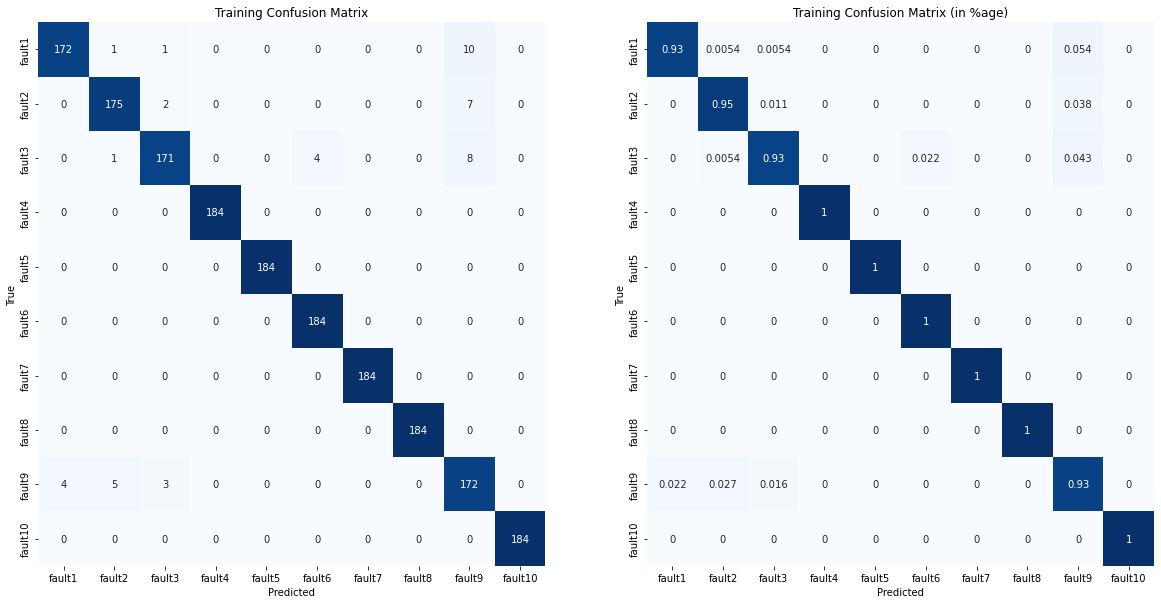

In [13]:
fault_type = ['fault1','fault2','fault3','fault4','fault5','fault6','fault7','fault8','fault9','fault10']
plt.figure(1,figsize=(20,10))
plt.subplot(121)
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(train_confu_matrix/184, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

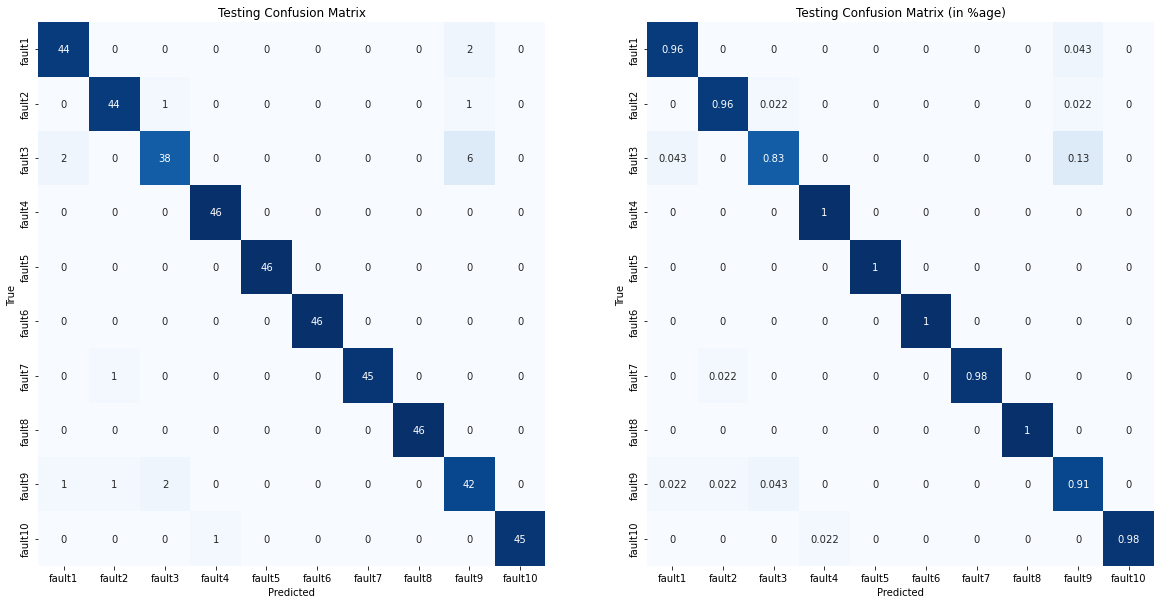

In [15]:
fault_type = ['fault1','fault2','fault3','fault4','fault5','fault6','fault7','fault8','fault9','fault10']
plt.figure(1,figsize=(20,10))
plt.subplot(121)
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(test_confu_matrix/46, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Testing Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()